In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy,sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import os
import glob
import shutil
import random
from keras.models import Model
import pickle
from keras.applications.vgg16 import preprocess_input

from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
import joblib
from joblib import Parallel, delayed

In [2]:
classes_=[]
for i in os.listdir('C:\\Users\\tirth\\Desktop\\prac\\prac4\\archive\\animals\\animals'):
    classes_.append(i)

In [3]:
os.chdir('C:\\Users\\tirth\\Desktop\\prac\\prac4\\archive\\animals')
if os.path.isdir('test') is False:
    for animal in classes_:
        os.makedirs('train/'+animal)
        os.makedirs('valid/'+animal)
        os.makedirs('test/'+animal)
        for c in random.sample(glob.glob('animals/'+animal+'/*'),50):
            shutil.move(c,'train/'+animal)
        for c in random.sample(glob.glob('animals/'+animal+'/*'),5):
            shutil.move(c,'valid/'+animal)
        for c in random.sample(glob.glob('animals/'+animal+'/*'),5):
            shutil.move(c,'test/'+animal)

In [4]:
train_path='C:\\Users\\tirth\\Desktop\\prac\\prac4\\archive\\animals\\train'
valid_path='C:\\Users\\tirth\\Desktop\\prac\\prac4\\archive\\animals\\valid'
test_path='C:\\Users\\tirth\\Desktop\\prac\\prac4\\archive\\animals\\test'

In [5]:
train_batches=ImageDataGenerator(
    rescale=1./255
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path,target_size=(224,224),classes=classes_,batch_size=10
    )
valid_batches=ImageDataGenerator(
    rescale=1./255
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path,target_size=(224,224),classes=classes_,batch_size=10
    )
test_batches=ImageDataGenerator(
    rescale=1./255
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,target_size=(224,224),classes=classes_,batch_size=10,shuffle=False
    )

Found 4500 images belonging to 90 classes.
Found 450 images belonging to 90 classes.
Found 450 images belonging to 90 classes.


In [6]:
# model=Sequential([
#     Conv2D(filters=64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     Dropout(0.2),
    
#     Conv2D(filters=128,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=128,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     Dropout(0.2),

#     Conv2D(filters=256,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=256,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=256,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     Dropout(0.2),

#     Conv2D(filters=512,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=512,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=512,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     Dropout(0.2),

#     Conv2D(filters=512,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=512,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     Conv2D(filters=512,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'),
#     MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     Dropout(0.2),
    
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(10,activation='softmax')
# ])

In [7]:
early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''

base_model = Xception(input_shape = (224,224,3),  weights='imagenet',include_top=False)
xception_model=Sequential()
# # freeze layers of predefined model.
# for layer in model.layers:  
#     layer.trainable = False
xception_model.add(base_model)
xception_model.add(GlobalAveragePooling2D())
xception_model.add(Dropout(0.3))
xception_model.add(Dense(90, activation='softmax'))               

In [8]:
xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 90)                184410    
                                                                 
Total params: 21,045,890
Trainable params: 20,991,362
Non-trainable params: 54,528
_________________________________________________________________


In [9]:
xception_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
xception_model.fit(x=train_batches,validation_data=valid_batches,batch_size=10,epochs=20,callbacks=[early_stopping],steps_per_epoch=50,verbose=2)

Epoch 1/20
50/50 - 39s - loss: 4.3442 - accuracy: 0.0780 - val_loss: 3.7441 - val_accuracy: 0.2444 - 39s/epoch - 787ms/step
Epoch 2/20
50/50 - 17s - loss: 3.6226 - accuracy: 0.3360 - val_loss: 2.7664 - val_accuracy: 0.4800 - 17s/epoch - 342ms/step
Epoch 3/20
50/50 - 17s - loss: 2.8710 - accuracy: 0.5400 - val_loss: 1.9610 - val_accuracy: 0.5956 - 17s/epoch - 347ms/step
Epoch 4/20
50/50 - 18s - loss: 2.3236 - accuracy: 0.6020 - val_loss: 1.4121 - val_accuracy: 0.6956 - 18s/epoch - 358ms/step
Epoch 5/20
50/50 - 18s - loss: 1.8010 - accuracy: 0.6760 - val_loss: 1.1359 - val_accuracy: 0.7511 - 18s/epoch - 367ms/step
Epoch 6/20
50/50 - 19s - loss: 1.4515 - accuracy: 0.7340 - val_loss: 0.9467 - val_accuracy: 0.7911 - 19s/epoch - 374ms/step
Epoch 7/20
50/50 - 19s - loss: 1.1577 - accuracy: 0.7900 - val_loss: 0.7908 - val_accuracy: 0.8267 - 19s/epoch - 373ms/step
Epoch 8/20
50/50 - 19s - loss: 0.9054 - accuracy: 0.8180 - val_loss: 0.7040 - val_accuracy: 0.8356 - 19s/epoch - 378ms/step
Epoch 9/

This has been run for 20 epochs

In [10]:
pred=xception_model.predict(test_batches)

45/45 [==============================] - 8s 122ms/step


badger


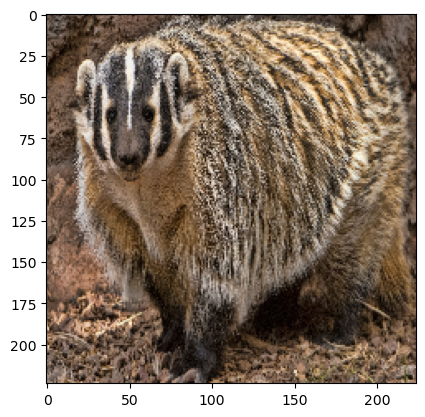

In [11]:
plt.imshow(test_batches[0][0][8])
print(classes_[np.argmax(pred[8])])

In [12]:
for i in pred:
    print(classes_[np.argmax(i)])

antelope
antelope
antelope
antelope
antelope
badger
badger
badger
badger
badger
bat
bat
bat
bat
bat
hamster
bear
bear
bear
bear
bee
bee
bee
bee
bee
beetle
beetle
beetle
beetle
beetle
bison
bison
bison
bison
bison
boar
boar
cow
boar
boar
butterfly
butterfly
butterfly
butterfly
butterfly
cat
cat
cat
cat
cat
caterpillar
caterpillar
porcupine
caterpillar
caterpillar
chimpanzee
chimpanzee
chimpanzee
chimpanzee
chimpanzee
cockroach
cockroach
cockroach
cockroach
cockroach
cow
pig
cow
cow
cow
coyote
bat
coyote
wolf
coyote
crab
crab
crab
crab
crab
crow
crow
crow
crow
crow
deer
ox
deer
deer
reindeer
dog
dog
dog
dog
dog
whale
dolphin
dolphin
dolphin
dolphin
donkey
donkey
donkey
donkey
goat
dragonfly
dragonfly
dragonfly
dragonfly
dragonfly
duck
duck
duck
duck
duck
octopus
eagle
eagle
eagle
eagle
elephant
elephant
elephant
elephant
elephant
flamingo
flamingo
flamingo
flamingo
flamingo
fly
fly
fly
mosquito
fly
fox
fox
fox
fox
fox
goat
goat
goat
goat
goat
goldfish
goldfish
goldfish
goldfish
goldfish


In [14]:
joblib.dump(xception_model,'animal_analyze(xception).pkl')

INFO:tensorflow:Assets written to: ram://45080ffb-9ef2-465d-9837-33d581fe6b90/assets


INFO:tensorflow:Assets written to: ram://45080ffb-9ef2-465d-9837-33d581fe6b90/assets


['animal_analyze(xception).pkl']